## Example code for fitting a simple function (straight line) using Linear Least Squares and Orthogonal Distance Regression

OLS slope:  1.392193064985155
OLS intercept:  7.129716534467654
R:  0.6474524257816604
Beta: [1.86608177 2.91189081]
Beta Std Error: [0.06167335 0.82343773]
Beta Covariance: [[ 0.00236747 -0.02891509]
 [-0.02891509  0.4220379 ]]
Residual Variance: 1.6066085333809232
Inverse Condition #: 0.02909711760706423
Reason(s) for Halting:
  Sum of squares convergence

ODR regression
slope:  1.8660817742754074  +/-  0.06167334861878896
intercept:  2.9118908088154885  +/-  0.82343772594355


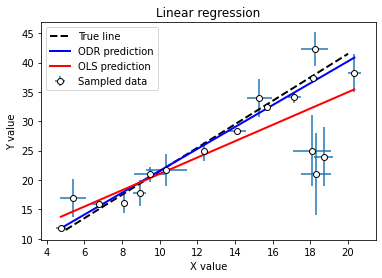

In [36]:
'''
---------------------------------------------------------------------
Example python code for fitting a simple model to data with errors
in both x and y

Uses routines from scipy.odr, Orthogonal Distance Regression

                                           Roderick Brown, 31/3/2020
 --------------------------------------------------------------------
'''
%matplotlib inline

# -*- coding: utf-8 -*-

# Import required modules
import numpy as np
import scipy.odr.odrpack as odrpack
from scipy import stats
#from scipy.optimize import curve_fit
import csv
import matplotlib.pyplot as plt

# Provide path to data file to read data from
#filename = '/Users/rod/src/python/python/python/mull_gravity.txt' # Simple tab delimeted ascii text file with data to be read in

# create some data
size = 15 # number of values to generate
true_intercept = 1.5
true_slope = 2.0
np.random.seed(321) # set random seed so repeated runs are identical

X = np.linspace(5, 20, size)
# y = a + b*x
Y = true_intercept + true_slope * X

# add some outliers, i.e. "real" outliers, set variance, as in made up :-)
x_outliers = [18.1,18.3,18.7]
y_outliers = [25.,21.,24.]
sy_outliers = [6.,7.,5.] #np.random.normal(scale=10., size=len(y_outliers))
sx_outliers = [1.,0.8,0.5] #np.random.normal(scale=0.5, size=len(x_outliers))

# generate errors on "real" data using normal distribution (variance is constant)
SY = np.random.normal(scale=2., size=len(Y))
SX = np.random.normal(scale=0.8, size=len(X))
# add noise/errors to sampled data
Xdata = X + SX
Ydata = Y + SY

Xvalues = np.append(Xdata,x_outliers)
Yvalues = np.append(Ydata,y_outliers)
Xerrors = np.append(SX,sx_outliers)
Yerrors = np.append(SY,sy_outliers)
#append the outliers to the sampled data


residuals=[]

#print (X)
#print (SX)
#print (SY)
#print (Xdata)
#print (Ydata)

'''
# Read x,y data into 2D array from text file using genfromtxt
#DataIn = np.genfromtxt(filename, comments="#", usecols=(0,1,2,3))

X=DataIn[:,0]       # Assign first column to x variable, distance in km
SX=DataIn[:,1]      # Assign second column to sx, stddev of x variable, distance in km
Y=DataIn[:,2]       # Assign third column to y variable, Bouguer anomaly, mGal
SY=DataIn[:,3]      # Assign fourth column to sy, stddev of y variable, gravity in mGal
X=X*1000.           # Convert x values from km to metres
'''

slope_ols, intercept_ols, r_value, p_value, std_err = stats.linregress(Xvalues,Yvalues)
print ('OLS slope: ',slope_ols)
print ('OLS intercept: ',intercept_ols)
print ('R: ',r_value**2)

# Scipy's ODR, Orthogonal Distance Regression library (errors on x, y data included)
#-----------------------------------------------------------

def linear(B,x): # linear model with B[0] as slope and B[1] as intercept
    return(B[0]*x + B[1])

# Do ODR regression
#---------------------------------------------------------------------
# Instantiate a model object using the spherical model defined above
model = odrpack.Model(linear)

# Instantiate a real data object to hold the observed data
data = odrpack.RealData(Xvalues, Yvalues, sx=Xerrors, sy=Yerrors)

# Pass data object and spherical model object to ODR solver
odrsolver = odrpack.ODR(data, model, beta0=[1.,1.])

# Run the ODR object and store output in myoutput#
myoutput = odrsolver.run()

# Print summary of output of ODR to stdout (i.e. screen)
myoutput.pprint()

# Extract some useful stats and store them in named variables to use later
slope_odr=myoutput.beta[0]
err_slope_odr=myoutput.sd_beta[0]
intercept_odr=myoutput.beta[1]
err_intercept_odr=myoutput.sd_beta[1]

# Calculate fitted value of y at each x location, and the residuals
# at each location using optimum parameters returned by ODR regression
modelY = []
for i in range (0,len(Xvalues)):
     modelY.append(intercept+ slope*Xvalues[i])
     residuals.append(modelY[i]-Yvalues[i])

# Print essential parameters and error estimates to stdout, i.e. screen
print ('\nODR regression')
print ('slope: ', slope, ' +/- ', err_slope)
print ('intercept: ', intercept, ' +/- ',err_intercept)


# Draw plot (basically a simple x,y graph, uses matplotlib routines from pyplot)
#--------------------------------------------------------
plt.figure(1)

# Set various axes and labels etc
plt.title('Linear regression')
plt.xlabel('X value')
plt.ylabel('Y value')
# Set min, max values for x,y axes
#plt.axis([-30000,50000,-15.,70.])

# Plot true line
plt.plot(X,Y,'k--',linewidth=2, label='True line')
# plot sampled data with errors

# Place all kwargs for xy data plot style in a dictionary, arguably tidier and easier to read/edit
style_data = {'marker':'o','markersize':6, 'markerfacecolor':'w', 'markeredgecolor':'k',\
              'elinewidth':1.5,'linewidth':0, 'label':'Sampled data'}
plt.errorbar(Xvalues, Yvalues, Yerrors, Xerrors, **style_data)

# Plot predictions for ODR and OLS methods
# Place all kwargs for plot style in a dictionary. tidier and easier to read/edit
style_odr={'color':'blue','linewidth':2,'linestyle':'-','label':'ODR prediction'}
style_ols={'color':'red','linewidth':2,'linestyle':'-','label':'OLS prediction'}

plt.plot(Xdata,(slope_odr*Xdata+intercept_odr), **style_odr)
plt.plot(Xdata,(slope_ols*Xdata+intercept_ols), **style_ols)

# Plot residuals (i.e. model - observed)
#plt.plot(x,residuals, '+', markersize=6, markerfacecolor='w', markeredgecolor='r', label='ODR Residuals')


#Plot legend
plt.legend(loc='upper left')

# Write plot to pdf file
#plt.savefig('regression_example.pdf', format='pdf')

# Show the plot on screen
plt.show()
